In [1]:
import sys

In [2]:
sys.path.insert(0,'../')

In [3]:
import pyathena as pa

In [4]:
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCR

## NOTE on the directory specification
Below, `save_dir` is the path to the directory where you want to store temporary files.
However, this is also the path where the pre-computed projection outputs will be searched.
If it doesn't have the corresponding files, the code will try to read the full 3D data and then create a file to store the projection data.
Thus, it would be better if you **COPY** the `prj/` folder from the `orig_dir` to `save_dir`


In [5]:
orig_dir="/projects/EOSTRIKE/TIGRESS-NCR/R8_4pc_NCR.full.xy2048.eps0.np768.has/"   # path to the original data
save_dir="/scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR" # path to the directory where temporary files to be stored
s=LoadSimTIGRESSNCR(orig_dir,verbose=True,savdir=save_dir)

[LoadSimTIGRESSNCR-INFO] basedir: /projects/EOSTRIKE/TIGRESS-NCR/R8_4pc_NCR.full.xy2048.eps0.np768.has
[LoadSimTIGRESSNCR-INFO] savdir: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR
[LoadSimTIGRESSNCR-INFO] load_method: xarray
[FindFiles-INFO] athinput: /projects/EOSTRIKE/TIGRESS-NCR/R8_4pc_NCR.full.xy2048.eps0.np768.has/out.txt
[FindFiles-INFO] athena_pp: False
[FindFiles-INFO] problem_id: R8_4pc_NCR
[FindFiles-INFO] vtk in tar: /projects/EOSTRIKE/TIGRESS-NCR/R8_4pc_NCR.full.xy2048.eps0.np768.has/vtk nums: 200-500
[FindFiles-WARNING] Vtk file size is not unique.
[FindFiles-WARNING] vtk num: 0, size [MB]: 8834
[FindFiles-WARNING] vtk num: 1, size [MB]: 8834
[FindFiles-WARNING] vtk num: 2, size [MB]: 8834
[FindFiles-WARNING] vtk num: 3, size [MB]: 8834
[FindFiles-WARNING] vtk num: 4, size [MB]: 8834
[FindFiles-WARNING] vtk num: 5, size [MB]: 8834
[FindFiles-WARNING] vtk num: 6, size [MB]: 8834
[FindFiles-WARNING] vtk num: 7, size [MB]: 8834
[FindFiles-WARNING] vtk num: 8, size [MB]: 883

xi_CR0 not found. Use 2e-16.


In [6]:
# "save_dir" didn't exist, the code will create a empty folder.
# as explained, you might want to copy "prj/" to there
# following command can do this
import shutil
# copy files only when the desination folder is not there
if not os.path.isdir(os.path.join(save_dir,"prj")):
    shutil.copytree(os.path.join(orig_dir,"prj"),os.path.join(save_dir,"prj"))

In [7]:
# path to the data files are now stored as a dictionary
s.files.keys()

dict_keys(['athinput', 'vtk_tar', 'hst', 'sn', 'zprof', 'starpar_vtk', 'timeit'])

In [8]:
# snapshot numbers for the original 3D data array is stored in the "nums"
print(f"{len(s.nums)} snapshots are available from {s.nums[0]} to {s.nums[-1]}")

301 snapshots are available from 200 to 500


In [9]:
# pre calculated projection data can be accessed by passing the corresponding snapshot number to the "read_prj" method
prj = s.read_prj(s.nums[-1])

[LoadSimTIGRESSNCR-INFO] Read from existing pickle: /scratch/gpfs/changgoo/TIGRESS-NCR/R8_4pc_NCR/prj/prj_0500.p


In [10]:
# the data you get is a dictionary
prj.keys()

dict_keys(['extent', 'time', 'x', 'y', 'z'])

In [11]:
# top-down projection data (projection along the z axis)
prj_z = prj["z"]

In [12]:
# These are available projection data. All Sigma_* field are in Msun/pc^2 units, while the EM fieldis in cm^-6*pc.
prj_z.keys()

dict_keys(['Sigma_gas', 'Sigma_HI', 'Sigma_H2', 'Sigma_HII', 'Sigma_e', 'EM', 'Sigma_scalar0', 'Sigma_scalar1'])

In [13]:
# load the particle information for the same snapshot
sp = s.load_starpar_vtk(s.nums[-1])

[LoadSimTIGRESSNCR-INFO] [load_starpar_vtk]: R8_4pc_NCR.0500.starpar.vtk. Time: 499.685700


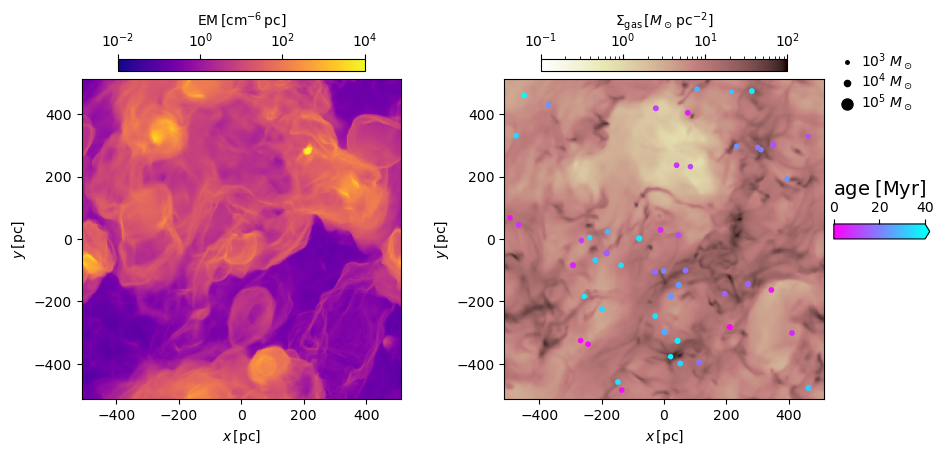

In [14]:
# This is an example script to create a nice looking figure (something similar to what's in the paper)
fig, axs = plt.subplots(1,2, figsize=(10,5))
axes = dict()
plot_kwargs=dict()
plot_kwargs["Sigma_gas"] = dict(
    label=r"$\Sigma_{\rm gas}\,[M_\odot\,{\rm pc^{-2}}]$",
    norm=LogNorm(1.0e-1, 1.0e2),
    cmap=plt.cm.pink_r,
)
plot_kwargs["EM"] = dict(
    label=r"${\rm EM}\,[{\rm cm^{-6}\,pc}]$",
    norm= LogNorm(1.0e-2, 1.0e4),
    cmap=plt.cm.plasma,
)
for i, f in enumerate(["EM","Sigma_gas"]):
    ax = axs[i]
    axes[f] = ax
    plt.sca(ax)
    im = plt.imshow(
        prj["z"][f],
        extent=prj["extent"]["z"],
        **plot_kwargs[f]
    )
    cbar = plt.colorbar(
        im,
        pad=0.02,
        shrink=0.7,
        location="top",
        label=plot_kwargs[f]["label"])
    ax.set_aspect("equal")
    ax.set_xlabel(r"$x\,[{\rm pc}]$")
    ax.set_ylabel(r"$y\,[{\rm pc}]$")

# There are some scripts I've wrote to ease particle plotting,
from pyathena.plt_tools.plt_starpar import scatter_sp, colorbar_sp, legend_sp

ax = axes["Sigma_gas"]
scatter_sp(sp, ax, "z", kpc=False, norm_factor=5, u=s.u, agemax=40)
legend_sp(ax, norm_factor=5, mass=[1.0e3, 1.0e4, 1.e5], location="right")
bbox = ax.get_position()
lx = bbox.x1 - bbox.x0
ly = bbox.y1 - bbox.y0
dx = lx*0.2
dy = ly * 0.1
bbox = [bbox.x1 + 0.01, bbox.y0 + 0.5*ly, 0.3*lx, 0.03]
colorbar_sp(fig, 40, bbox=bbox)
